# Setup environment

In [1]:
import numpy as np
from numpy.linalg import inv
import math
from scipy.stats import mode

import matplotlib.pyplot as plt
import seaborn as sns

# Model

## KNN

Hypothesis:

We wan to predict the value of a given a datapoint $y_i$ based in a point $x_i$.

$$y_i = H(x_i)$$

$x_i$ is composed by the features $f_0, f_1, ..., f_n$:

$$ x_i = (f_0, f_1, ...,  f_n)$$ 

Since we don't have the function $H(x)$ to calculate the value of $y_i$, we can assume that this value is similar to the closest values:

$$ y_i \sim y_j \rightarrow y_j = H(x_j)$$

in this case:
$$
x_j = \min_{j}\{ d(x_i, x_j) \}_{j=0; j \neq i}^{n} 
$$

So basically we need to find the minimum distance. To do that we can use different methods, but in this case the selected was the Euclidean distance:

#### Euclidean Distance:

$$
d\left( x_i,x_j\right)   = \sqrt {\sum _{k=0}^{n}  \left( f_{i(k)}-f_{j(k)}\right)^2 } 
$$

In [2]:
def euclidean_distance(xi, xj):
  return np.sqrt(np.sum((xi - xj)**2)) 

Now we can implement knn

In [3]:
class KNN:
  def __init__(self, k, X, Y):
      self.k = k
      self.X = X
      self.Y = Y

  def predict(self, X_pred):
      predictions = []
      for x_pred in X_pred:
          predictions.append(self.get_prediction(x_pred))

      predictions = np.array(predictions)

      return predictions

  
  def get_prediction(self, x_pred):
      # Get Euclidean distance
      distances = self.get_distances(x_pred)

      # Get closest 3 values
      nearest_index = np.argsort(distances)[:self.k]


      y_pred = []
      for i in range(self.k):
          y_pred.append(self.Y[nearest_index[i]])

      y_pred = mode(y_pred)[0][0]
      #print(y_pred)

      return y_pred

  def get_distances(self, x_pred):
      distances = []
      for x in self.X:
          distances.append(euclidean_distance(x_pred, x))

      distances = np.array(distances)
      return distances

# Classification

### 1. Dataset

In [4]:
def add_noise(arr, level, v=True):
  noise = np.random.normal(0, level/2, len(arr))
  if v:
    plt.hist(noise)
    plt.show()

  arr = arr + noise
  
  return arr

In [5]:
def generate_classes(Y):
    #limit = Y.max()/2 
    limit = np.median(Y)
    Y_aux = []
    for y in Y:
      if y > limit:
        Y_aux.append(1)
      else:
        Y_aux.append(0)
    Y = np.array(Y_aux)
    return Y

In [6]:
# Dataset:
# Create random input and output data
x1 = np.random.normal(10, 10/2, 2000)
x2 = np.random.normal(15, 10/2, 2000)
x3 = np.random.normal(8, 3/2, 2000)

X = np.stack([x1, x2, x3]).T

# Create output data
Y = (1 + (x1 * 3) + (x2 * 4) + (x3 * 2)).T

Y = add_noise(Y, np.median(Y)/100, v=False)
Y = generate_classes(Y)

# Add noise to x
X[:, 0] = add_noise(X[:, 0], 1, v=False)
X[:, 1] = add_noise(X[:, 1], 2, v=False)
X[:, 2] = add_noise(X[:, 2], .5, v=False)

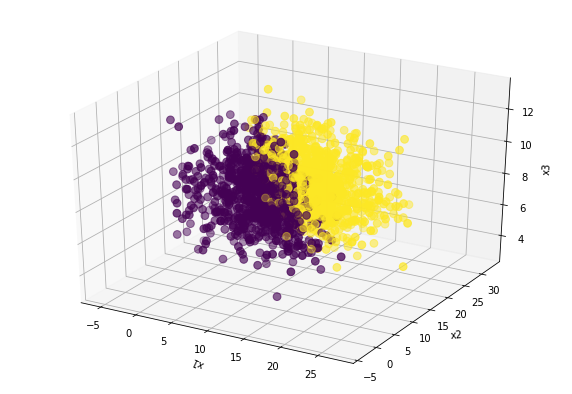

In [7]:
# X vs y
# Create the instance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=60, c=Y)

# axis: 'x', 'y' y 'z'
ax.set_xlabel('x1', fontsize=10, rotation=155)
ax.set_ylabel('x2', fontsize=10, rotation=5)
ax.set_zlabel(r'x3', fontsize=10, rotation=87)

plt.show()

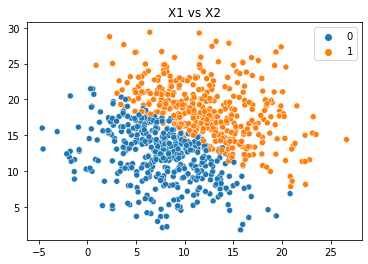

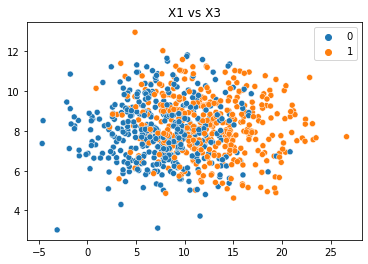

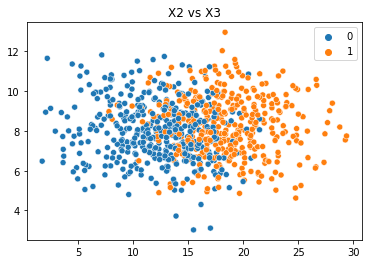

In [8]:
# x1 vs x2
sns.scatterplot(x=x1[:int(len(x1)*.4)], y=x2[:int(len(x2)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X1 vs X2")
plt.show()

# x1 vs x3
sns.scatterplot(x=x1[:int(len(x1)*.4)], y=x3[:int(len(x3)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X1 vs X3")
plt.show()

# x2 vs x3
sns.scatterplot(x=x2[:int(len(x2)*.4)], y=x3[:int(len(x3)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X2 vs X3")
plt.show()

In [9]:
def split_train_test(x, y, train_set=80):
  index = np.arange(len(y))
  np.random.shuffle(index)

  print(f'The train set will be the {train_set}% of the dataset')
  
  # Test:
  test_index = index[int(len(y)*.8):]
  try:
    x_test = x[test_index, :]
  except:
    x_test = x[test_index]
  y_test = y[test_index]

  # Train:
  train_index = index[:int(len(y)*.8)]
  try:
    x = x[train_index, :]
  except:
    x = x[train_index]

  y = y[train_index]

  print(f'The x train shape is: {x.shape} and y is: {y.shape}')
  print(f'The x test shape is: {x_test.shape} and y is: {y_test.shape}')

  return x, y, x_test, y_test

In [10]:
X, Y, x_test, y_test = split_train_test(X, Y)

The train set will be the 80% of the dataset
The x train shape is: (1600, 3) and y is: (1600,)
The x test shape is: (400, 3) and y is: (400,)


### 2. Model inference

In [11]:
knn = KNN(k=2, X=X, Y=Y)

### 3. Test: 

Now we are going to measure the performance of the model:

#### Accuracy


$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [12]:
def get_accuracy(y, y_hat):
  accuracy = np.sum(y_hat==y)/len(y)
  print(f'The accuracy is: {accuracy}')
  return accuracy

In [13]:
def evaluate(x_test, y_test, model):
  y_hat = knn.predict(x_test)
  get_accuracy(y_test, y_hat)

In [14]:
evaluate(x_test, y_test, knn)

The accuracy is: 0.9175


# Regression

### 1. Dataset

In [15]:
# Dataset:
# Create random input and output data
x1 = np.random.normal(10, 10/2, 2000)
x2 = np.random.normal(15, 10/2, 2000)
x3 = np.random.normal(8, 3/2, 2000)

X = np.stack([x1, x2, x3]).T

# Create output data
Y = (1 + (x1 * 3) + (x2 * 4) + (x3 * 2)).T

Y = add_noise(Y, np.median(Y)/100, v=False)

# Add noise to x
X[:, 0] = add_noise(X[:, 0], 1, v=False)
X[:, 1] = add_noise(X[:, 1], 2, v=False)
X[:, 2] = add_noise(X[:, 2], .5, v=False)

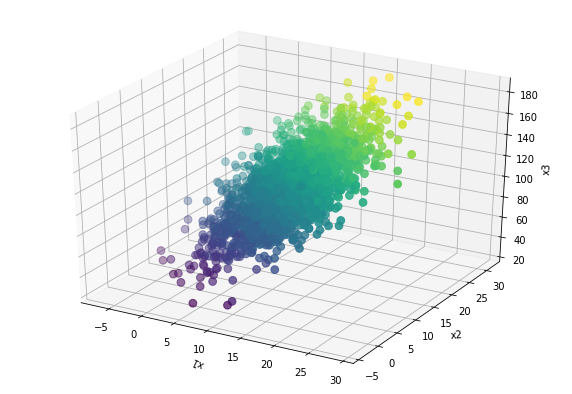

In [16]:
# X vs y
# Create the instance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, s=60, c=Y)

# axis: 'x', 'y' y 'z'
ax.set_xlabel('x1', fontsize=10, rotation=155)
ax.set_ylabel('x2', fontsize=10, rotation=5)
ax.set_zlabel(r'x3', fontsize=10, rotation=87)

plt.show()

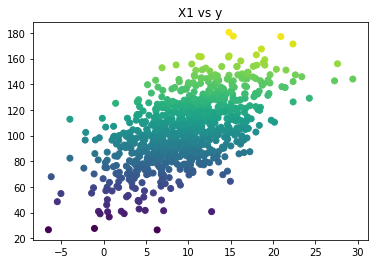

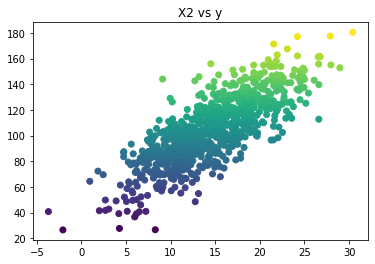

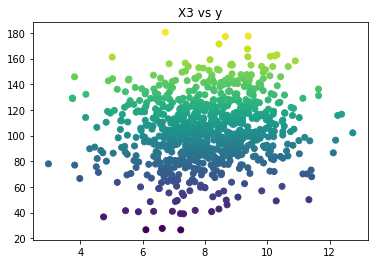

In [17]:
# x1 vs x2
plt.scatter(x=x1[:int(len(x1)*.4)], y=Y[:int(len(Y)*.4)], c=Y[:int(len(Y)*.4)])
plt.title("X1 vs y")
plt.show()

# x1 vs x3
plt.scatter(x=x2[:int(len(x2)*.4)], y=Y[:int(len(Y)*.4)], c=Y[:int(len(Y)*.4)])
plt.title("X2 vs y")
plt.show()

# x2 vs x3
plt.scatter(x=x3[:int(len(x3)*.4)], y=Y[:int(len(Y)*.4)], c=Y[:int(len(Y)*.4)])
plt.title("X3 vs y")
plt.show()

In [18]:
X, Y, x_test, y_test = split_train_test(X, Y)

The train set will be the 80% of the dataset
The x train shape is: (1600, 3) and y is: (1600,)
The x test shape is: (400, 3) and y is: (400,)


### 2. Model Inference

In [20]:
knn = KNN(k=2, X=X, Y=Y)

### 3. Test

#### Mean Squared Error(MSE)

$$
MSE = \frac{1}{n} \sum_{i=1}^{D}(y_i - \hat{y_i})^2
$$


#### Mean Absolute Error(MSE)

$$
MAE = \frac{1}{n} \sum_{i=1}^{D}y_i - \hat{y_i}
$$

In [21]:
def get_mse(y, y_hat):
  mse = np.square(np.subtract(y,y_hat)).mean()
  print(f'The MSE is: {mse}')
  return mse

def get_mae(y, y_hat):
  mae = np.abs(np.subtract(y,y_hat)).mean()
  print(f'The MAE is: {mae}')
  return mae

In [22]:
def evaluate_regression(x_test, y_test, model):
  y_hat = knn.predict(x_test)
  get_mse(y_test, y_hat)
  get_mae(y_test, y_hat)

In [23]:
evaluate_regression(x_test, y_test, knn)

The MSE is: 43.35067690704016
The MAE is: 5.240690642083386
